# Depth estimation of mono-camera images for Visual SLAM 

In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

img = cv2.imread('rgb/r0.png',1)
depth = cv2.imread('depth/d0.png', -1)
print(img.shape)
print(depth.shape)
plt.subplot(2,1,1)
plt.imshow(img)
plt.subplot(2,1,2)
plt.imshow(depth)
print(np.max(depth), np.min(depth))

In [ ]:
# !unzip example_dataset.zip

# Let's try to create an Autoencoder network (UNET)

Unet has three parts:
- Downsampling   (skip connection to upsampling)
- Bottleneck
- Upsampling

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 128, 128, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_152[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_153[0][0]                 
____________________________________________________________________________________________

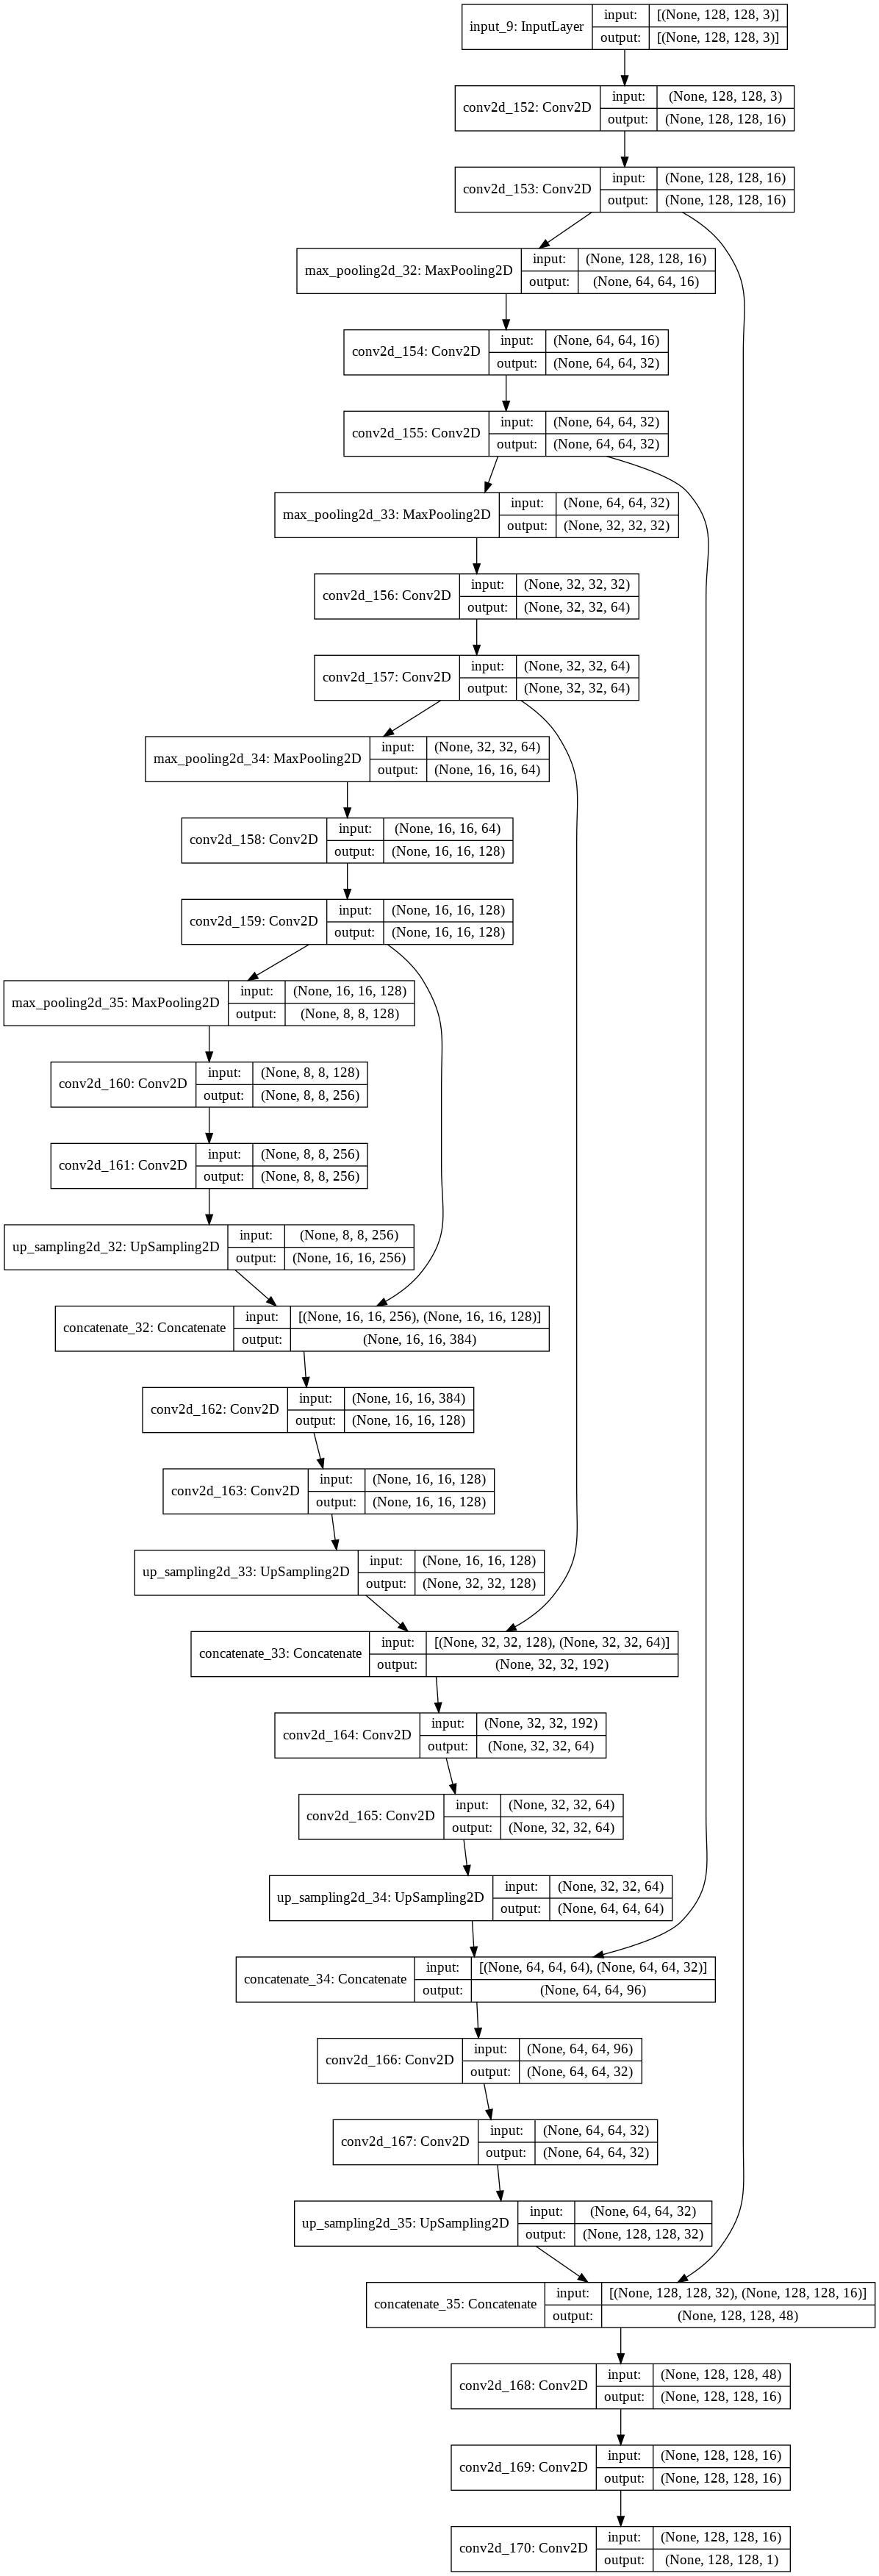

In [ ]:
def down_block(x, filters, kernel_s = (3,3), 
              padding_ = 'same', strides_ = 1, 
              activation_ = 'relu'):

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(conv1_layer)

    pooling_layer = MaxPool2D((2,2), strides=(2,2))(conv2_layer)

    return conv2_layer, pooling_layer


def up_block(x, skip, filters, kernel_s = (3,3), 
                     padding_ = 'same', strides_ = 1, 
                     activation_ = 'relu'):

    up_sampling_1 = UpSampling2D((2,2))(x)
    concat1 = Concatenate()([up_sampling_1, skip])

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(concat1)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(conv1_layer)

    return conv2_layer


def bottleneck(x, filters, kernel_s = (3,3), 
               padding_ = 'same', strides_ = 1, 
               activation_ = 'relu'):

    conv1_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(x)

    conv2_layer = Conv2D(filters, 
                        kernel_size=kernel_s, 
                        padding=padding_, 
                        strides=strides_, 
                        activation=activation_)(conv1_layer)
    return conv2_layer
  

def UNet(image_size, filters = [16, 32, 64, 128, 256]):
    inputs = keras.layers.Input([image_size, image_size, 3])

    p0 = inputs
    c1, p1 = down_block(p0, filters[0]) # 128 -> 64
    c2, p2 = down_block(p1, filters[1]) # 64  -> 32
    c3, p3 = down_block(p2, filters[2]) # 32  -> 16
    c4, p4 = down_block(p3, filters[3]) # 16  -> 8

    bn = bottleneck(p4, filters[4])

    u1 = up_block(bn, c4, filters[3]) # 8  -> 16
    u2 = up_block(u1, c3, filters[2]) # 16 -> 32
    u3 = up_block(u2, c2, filters[1]) # 32 -> 64
    u4 = up_block(u3, c1, filters[0]) # 64 -> 128

    outputs = Conv2D(1, kernel_size=(1,1), padding='same', activation='sigmoid')(u4)
    model = keras.models.Model(inputs, outputs)

    return model


model = UNet(image_size=128)
model.compile(optimizer='adam', loss='mse')
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# finish this later on...
import keras
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, batch_size = 8, image_size = 128):
    self.batch_size = batch_size
    self.image_size = image_size

  def load(self, rgb_file, depth_file):
    image = cv2.imread(rgb_file)
    image = cv2.resize(image, (self.image_size, self.image_size)) # resize...
    depth = cv2.imread(depth_file, -1)
    depth = cv2.resize(depth, (self.image_size, self.image_size)) 

    image_normalized = image/np.max(image)
    depth_normalized = depth/np.max(depth) # double check the depth images!
    return image_normalized, depth_normalized

  def load_all(self, rgb_files, depth_files):
      images = []
      depths = []
      for i in range(len(rgb_files)):
          img, dpth = self.load(rgb_files[i], depth_files[i])
          images.append(img)
          depths.append(dpth)

      return np.array(images), np.array(depths)

In [ ]:
# Get file names
rgb_images = os.listdir('rgb/')
rgb_images.sort()
rgb_images = [str('rgb/') + file for file in rgb_images]
depth_images = os.listdir('depth/')
depth_images.sort()
depth_images = [str('depth/') + file for file in depth_images]

test_size = 100
rgb_images_test = rgb_images[:test_size]
depth_images_test = depth_images[:test_size]

rgb_images_train = rgb_images[test_size:]
depth_images_train = depth_images[test_size:]

# Load data:

load_data = DataGenerator()

X_train, y_train = load_data.load_all(rgb_files=rgb_images_train, 
                                      depth_files=depth_images_train)

X_test, y_test = load_data.load_all(rgb_files=rgb_images_test, 
                                  depth_files=depth_images_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(506, 128, 128, 3) (506, 128, 128)
(100, 128, 128, 3) (100, 128, 128)


In [ ]:
model.fit(X_train, y_train, batch_size=8, epochs=5, validation_split=0.2)

Epoch 1/5
51/51 [==============================] - 71s 1s/step - loss: 0.0649 - val_loss: 0.0374
Epoch 2/5
51/51 [==============================] - 71s 1s/step - loss: 0.0469 - val_loss: 0.0382
Epoch 3/5
51/51 [==============================] - 70s 1s/step - loss: 0.0412 - val_loss: 0.0314
Epoch 4/5
51/51 [==============================] - 71s 1s/step - loss: 0.0378 - val_loss: 0.0337
Epoch 5/5
51/51 [==============================] - 72s 1s/step - loss: 0.0392 - val_loss: 0.0373


In [ ]:
preds = model.predict(X_test)

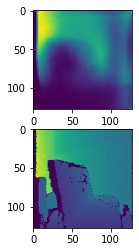

In [ ]:
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(2,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(2,1,2)
plt.imshow(y_test[0]*255)

In [ ]:
## Try to fill depth holes.
import copy
import os
import numpy as np
import cv2
import math

def Test(num_iter=10, eta=0.5, sigma_c=10.0, sigma_s=10.0, L=256):
    """
    @param sigma_c: sigma_color
    @param sigma_s: sigma_space
    implemention of "Spatial-Depth Super Resolution for Range Images"
    """
    src_path = 'r0.png'
    depthMap_path = 'd0.png'  

    src = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)  
    depthMap = cv2.imread(depthMap_path, cv2.IMREAD_GRAYSCALE)

    if src is None or depthMap is None:
        print('[Err]: empty input image.')
        return

    DEPTH_H, DEPTH_W = depthMap.shape

    assert src.shape == depthMap.shape

    # We will use our RGB image for depth prediction
    joint = src

    # Convert the images to float32
    joint = joint.astype('float32')
    depthMap = depthMap.astype('float32')

    cost_volume = np.zeros((DEPTH_H, DEPTH_W, 256), dtype='float32')
    cost_cw = np.zeros((DEPTH_H, DEPTH_W, 256), dtype='float32')

    THRESH = eta * L
    for iter_i in range(num_iter):
        for d in range(256):  # depth range
            tmp = np.empty((DEPTH_H, DEPTH_W))
            tmp.fill(d)

            cost_tmp = (tmp - depthMap) ** 2
            cost_tmp = np.where(cost_tmp < THRESH, cost_tmp, THRESH)
            cost_volume[:, :, d] = cost_tmp

            # Use bilateral filtering
            cost_cw[:, :, d] = cv2.ximgproc.jointBilateralFilter(joint,
                                                                 cost_volume[:, :, d],
                                                                 -1,
                                                                 sigma_c, sigma_s)
            print('Depth hypothesis %d cost filtered' % d)

        # Update depth
        # get min cost along channels(depth hypotheses)
        min_cost = np.min(cost_cw, axis=2)  # f(x): min cost
        min_cost_depths = np.argmin(cost_cw, axis=2)  # x: min cost indices
        # print(min_cost_depths)

        # Sub pixel depth estimation
        for y in range(DEPTH_H):
            for x in range(DEPTH_W):
                int_depth = min_cost_depths[y][x]

                if int_depth + 1 > 255 or int_depth - 1 < 0:
                    depthMap[y][x] = float(int_depth)

                else:
                    f_d = cost_cw[y][x][int_depth]
                    f_d_plus = cost_cw[y][x][int_depth + 1]
                    f_d_minus = cost_cw[y][x][int_depth - 1]
    
                    sub_depth = int_depth - ((f_d_plus - f_d_minus) / (
                        2.0 * (f_d_plus + f_d_minus - 2.0 * f_d)))
                    depthMap[y][x] = sub_depth

        mat2show = copy.deepcopy(depthMap)
        mat2show = np.round(mat2show)
        mat2show = mat2show.astype('uint8')
        cv2.imwrite('new_data/iter_depth2_%d.jpg' % (iter_i + 1), mat2show)
        print('=> iter %d for depth2 done\n' % (iter_i + 1))

Test()

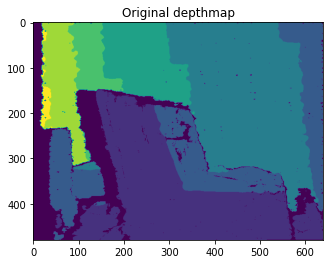

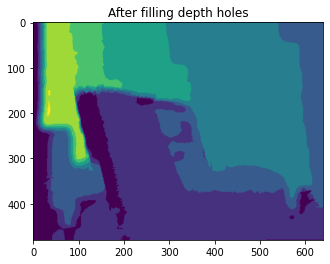

In [ ]:
# After filling holes:
depthMap1 = cv2.imread('d0.png', cv2.IMREAD_GRAYSCALE)
plt.title('Original depthmap')
plt.imshow(depthMap1)
plt.show()

depthMap = cv2.imread('new_data/filtered_depth.jpg', cv2.IMREAD_GRAYSCALE)
plt.title('After filling depth holes')
plt.imshow(depthMap)